# Homework 2
Christopher Liu

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import interp1d

from sklearn.linear_model import Lasso

In [3]:
time = np.linspace(1845,1903,num=30,endpoint='true') #2-year increments
dt1 = 2 #2 year increment

#Our Lynx and Hare Data
hare = np.array([20,20,52,83,64,68,83,12,36,150,110,60,7,10,70,100,92,70,10,11,137,137,18,22,52,83,18,10,9,65])
lynx = np.array([32,50,12,10,13,36,15,12,6,6,65,70,40,9,20,34,45,40,15,15,60,80,26,18,37,50,35,12,12,25])

#Interpolation for more points
hare_i = interp1d(time,hare, kind="cubic")
lynx_i = interp1d(time,lynx, kind="cubic")

In [4]:
#Time on a finer scale for interpolation
tfine = np.linspace(1845,1903,num=291,endpoint='true')
dt2 = 0.2 #0.2 year increment

# DMD

In [5]:
# DMD given X and X'. Only takes matrices
def DMD(x,xp):
    U,Sigma,VT = np.linalg.svd(x,full_matrices=0) #computing SVD
    Sigma = np.diag(Sigma) #convert from vector to matrix
    
    Atild = np.linalg.solve(Sigma.T,(U.T @ xp @ VT.T).T).T #computing A tilde using solve.
    lmda, W = np.linalg.eig(Atild) #eigenvalue decomposition
    lmda = np.diag(lmda) #covert vector to matrix
    
    phi =  xp @ np.linalg.solve(Sigma.T,VT).T @ W #calculate phi using solve
    a1 = Sigma@VT[:,0]
    b = np.linalg.solve(W@lmda, a1)
    
    return b, lmda, phi

In [6]:
# Reconstruction used to predict
def predict(b,lmbda,phi,t):
    xt = np.zeros((len(phi),t)) #might need to edit this later
    for i in range(0,t): 
        xt[:,i] = phi @ (lmbda**i)@b
    return xt

In [7]:
# Stacking the hare and lynx data into one matrix
pop = np.stack((hare_i(tfine),lynx_i(tfine)),axis=0) #row 0 is hare, row 1 is lynx

In [8]:
b, lmbda, phi = DMD(pop[:,0:145],pop[:,1:146])

In [9]:
xt = predict(b,lmbda,phi,291)

C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


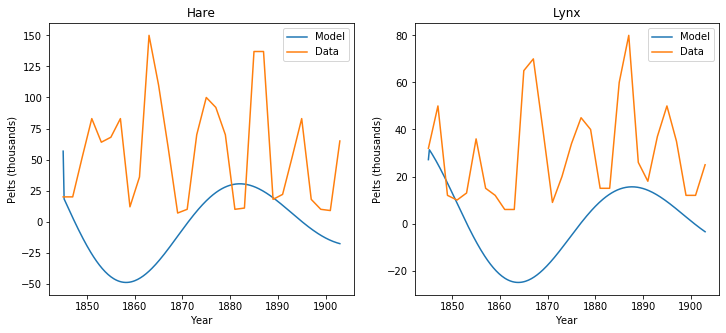

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(tfine,xt[0,:])
plt.plot(time,hare)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')
plt.title('Hare')

plt.subplot(1,2,2)
plt.plot(tfine,xt[1,:])
plt.plot(time,lynx)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')
plt.title('Lynx')

plt.savefig('DMD.png')

# Time Delay DMD

In [11]:
# Creates a Hankel matrix for a given set of data and steps. X must be a row vector.
def hankel(x,steps):
    H = np.zeros((steps,x.shape[0]-steps))
    for k in range(steps):
        H[k,:] = x[k:-(steps-k)]
    
    return H

## Non-interp

In [12]:
#Construct Hankel Matrix for each individual population (NON-INTERPOLATED DATA)
hare_h = hankel(hare,15)
lynx_h = hankel(lynx,15)

#splice them together (NON-INTERPOLATED DATA)
pop_h = np.zeros((hare_h.shape[0]*2,hare_h.shape[1]))
row_i = 0
for i in range(pop_h.shape[0]):
        if (i%2)==0:
            pop_h[i,:] = hare_h[row_i]
        elif (i%2)==1:
            pop_h[i,:] = lynx_h[row_i]
            row_i = row_i + 1

In [13]:
#SVD
UH, SH, VTH = np.linalg.svd(pop_h,full_matrices=0)

In [14]:
np.sum(SH)

3234.1517371553105

Text(0.5, 0, 'Singular Values')

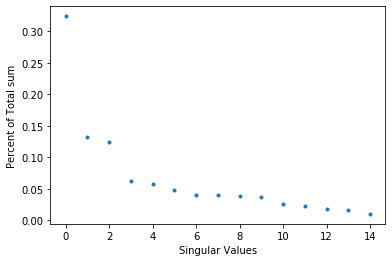

In [15]:
#Plot singular values

plt.plot(SH/np.sum(SH),'.')
plt.ylabel('Percent of Total sum')
plt.xlabel('Singular Values')

In [16]:
#testing trucnating for forecasting
hare_h_t = hankel(hare[0:14],10)
lynx_h_t = hankel(lynx[0:14],10)

#splice them together (NON-INTERPOLATED DATA)
poptrunc = np.zeros((hare_h_t.shape[0]*2,hare_h_t.shape[1]))
row_i = 0
for i in range(poptrunc.shape[0]):
        if (i%2)==0:
            poptrunc[i,:] = hare_h_t[row_i]
        elif (i%2)==1:
            poptrunc[i,:] = lynx_h_t[row_i]
            row_i = row_i + 1

In [17]:
#DMD
popt1 = poptrunc[:,0:-1]
popt2 = poptrunc[:,1:]

b_h, lmbda_h, phi_h = DMD(popt1,popt2)

In [18]:
xth = predict(b_h,lmbda_h,phi_h,30)

C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


Text(0, 0.5, 'Pelts (thousands)')

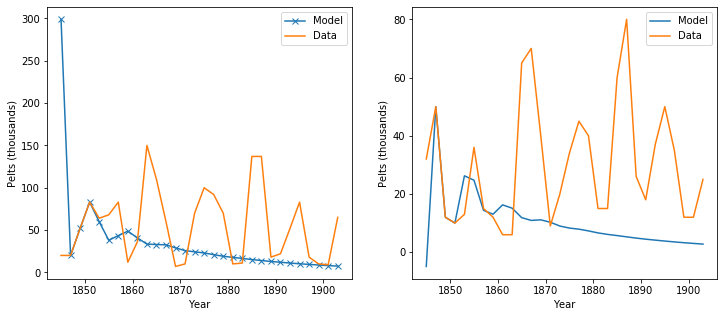

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(time[:],xth[0,:],'-x')
plt.plot(time,hare)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')

plt.subplot(1,2,2)
plt.plot(time,xth[1,:])
plt.plot(time,lynx)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')

## Interpolated

In [20]:
hare_h_i = hankel(hare_i(tfine),30)
lynx_h_i = hankel(lynx_i(tfine),30)

#splice them together (INTERPOLATED DATA)
pop_h_i = np.zeros((hare_h_i.shape[0]*2,hare_h_i.shape[1]))
row_i = 0
for i in range(pop_h_i.shape[0]):
        if (i%2)==0:
            pop_h_i[i,:] = hare_h_i[row_i]
        elif (i%2)==1:
            pop_h_i[i,:] = lynx_h_i[row_i]
            row_i = row_i + 1

In [21]:
#SVD
UHi, SHi, VTHi = np.linalg.svd(pop_h_i,full_matrices=0)

In [22]:
np.sum(SHi)

14188.113553833327

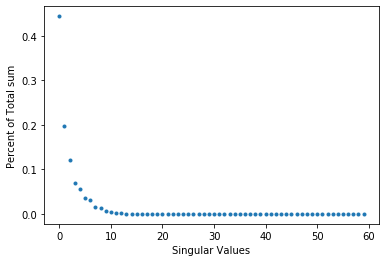

In [23]:
plt.plot(SHi/np.sum(SHi),'.')
plt.ylabel('Percent of Total sum')
plt.xlabel('Singular Values')

plt.savefig('SV1.png')

In [24]:
#Truncating for the forecast
harefine = hare_i(tfine)
lynxfine = lynx_i(tfine)
hare_h_it = hankel(harefine[0:145],30)
lynx_h_it = hankel(lynxfine[0:145],30)

#splice them together (INTERPOLATED DATA)
poptrunc_i = np.zeros((hare_h_it.shape[0]*2,hare_h_it.shape[1]))
row_i = 0
for i in range(poptrunc_i.shape[0]):
        if (i%2)==0:
            poptrunc_i[i,:] = hare_h_it[row_i]
        elif (i%2)==1:
            poptrunc_i[i,:] = lynx_h_it[row_i]
            row_i = row_i + 1

In [25]:
#DMD
popt1_i = poptrunc_i[:,0:-1]
popt2_i = poptrunc_i[:,1:]

b_h_i, lmbda_h_i, phi_h_i = DMD(popt1_i,popt2_i)

In [26]:
xth_i = predict(b_h_i,lmbda_h_i,phi_h_i,291)

C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


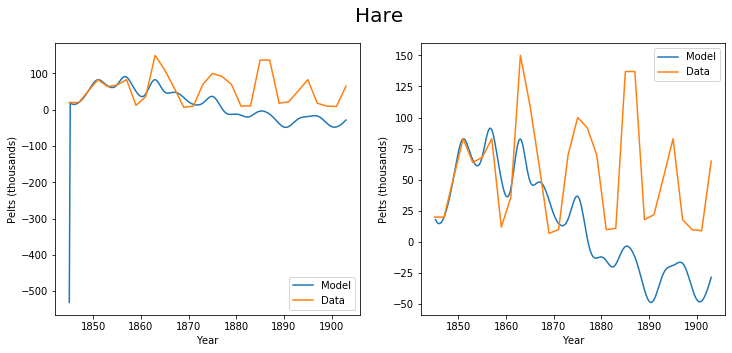

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(tfine[:],xth_i[0,:],'-')
plt.plot(time,hare)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')

plt.subplot(1,2,2)
plt.plot(tfine[1:],xth_i[0,1:],'-')
plt.plot(time,hare)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')

plt.suptitle('Hare',fontsize='20')
plt.savefig('htdmd.png')

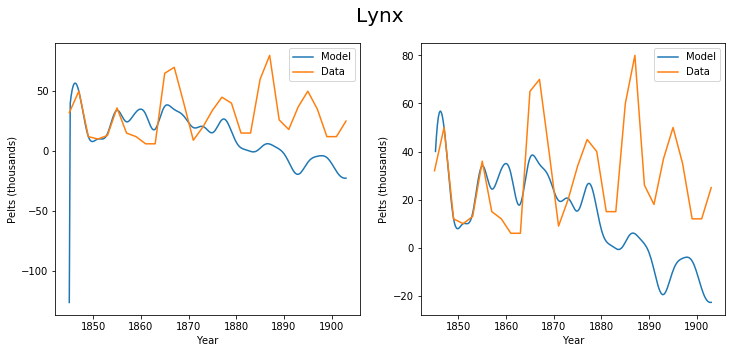

In [28]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(tfine[:],xth_i[1,:],'-')
plt.plot(time,lynx)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')

plt.subplot(1,2,2)
plt.plot(tfine[1:],xth_i[1,1:],'-')
plt.plot(time,lynx)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')

plt.suptitle('Lynx',fontsize='20')

plt.savefig('ltdmd.png')

# Lotka-Volterra

$$\dot{x}=(b-py)x$$ 
$$\dot{y}=(rx-d)y$$

## Trying non-interpolated data first

In [102]:
#Lotka-Volterra system of ODEs
def lvode(X,t=0):
     return np.array([ b*X[0] + p*X[0]*X[1] ,
                  +d*X[1] + r*X[0]*X[1] ])

In [30]:
#Calculating derivatives of data using centered 2nd-order accurate finite difference
haredot = np.zeros(hare.shape[0]-2)
lynxdot = np.zeros(lynx.shape[0]-2)
dt = 2

for i in range(1,hare.shape[0]-1):
    haredot[i-1] = (hare[i+1]-hare[i-1])/(2*dt)
    lynxdot[i-1] = (lynx[i+1]-lynx[i-1])/(2*dt)

In [31]:
#Creating Library functions
Ahare = np.array([hare[1:29], (hare*lynx)[1:29]])
Alynx = np.array([lynx[1:29],(hare*lynx)[1:29]])
Ahare = Ahare.T
Alynx = Alynx.T

In [32]:
#Fitting
hare_w =np.linalg.pinv(Ahare)@haredot
lynx_w = np.linalg.pinv(Alynx)@lynxdot

b = hare_w[0]
p = hare_w[1]
d = lynx_w[0]
r = lynx_w[1]

In [33]:
hare_w

array([ 0.15582505, -0.00384799])

In [34]:
lynx_w

array([-0.20457125,  0.00236625])

In [35]:
# Using our fitted coefficients to create our model
X0 = np.array([hare[0], lynx[0]])                     
LVsol= integrate.odeint(lvode, X0, time, full_output=True)

In [36]:
LVhare = LVsol[0][:,0]
LVlynx = LVsol[0][:,1]

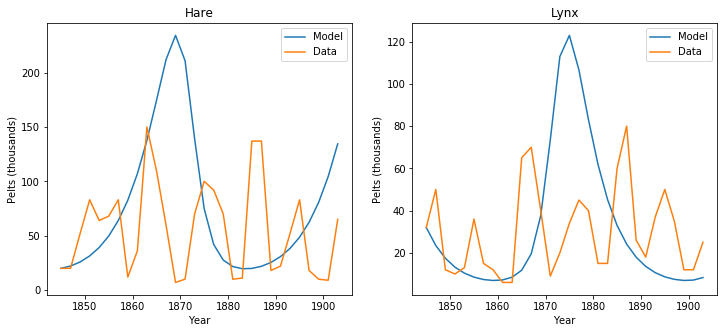

In [37]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(time[:],LVhare)
plt.plot(time,hare)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')
plt.title('Hare')

plt.subplot(1,2,2)
plt.plot(time[:],LVlynx)
plt.plot(time,lynx)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')
plt.title('Lynx')

plt.savefig('lv.png')

## Interpolated Data

In [103]:
haref = hare_i(tfine)
lynxf = lynx_i(tfine)

haredot_i = np.zeros(haref.shape[0]-2)
lynxdot_i = np.zeros(lynxf.shape[0]-2)
dti = 0.2

for j in range(1,haref.shape[0]-1):
    haredot_i[i-1] = (haref[j+1]-haref[j-1])/(2*dti)
    lynxdot_i[i-1] = (lynxf[j+1]-lynxf[j-1])/(2*dti)

In [104]:
#Creating Library functions
Ahare_i = np.array([haref[1:-1], (haref*lynxf)[1:-1]])
Alynx_i = np.array([lynxf[1:-1],(haref*lynxf)[1:-1]])
Ahare_i = Ahare_i.T
Alynx_i = Alynx_i.T

In [105]:
#Fitting
hare_w_i =np.linalg.pinv(Ahare_i)@haredot_i
lynx_w_i = np.linalg.pinv(Alynx_i)@lynxdot_i

b = hare_w_i[0]
p = hare_w_i[1]
d = lynx_w_i[0]
r = lynx_w_i[1]

In [41]:
hare_w_i

array([ 0.00869885, -0.0001423 ])

In [42]:
lynx_w_i

array([1.55042953e-04, 4.57987030e-08])

In [43]:
X0_i = np.array([haref[0], lynxf[0]])                     
LVsol_i= integrate.odeint(lvode, X0_i, tfine, full_output=True)

In [44]:
LVhare_i = LVsol_i[0][:,0]
LVlynx_i = LVsol_i[0][:,1]

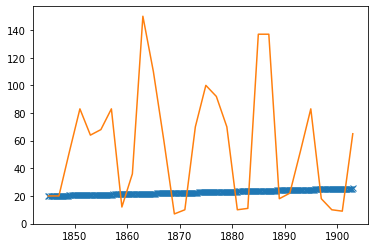

In [45]:
#doesn't look too great even if it might produce a better model?

plt.plot(tfine,LVhare_i,'-x')
plt.plot(time,hare)

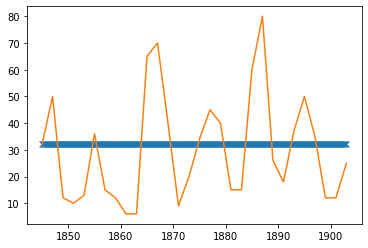

In [46]:
plt.plot(tfine,LVlynx_i,'-x')
plt.plot(time,lynx)

# Sparse Regression

Library functions, $$x,y,x^2,y^2,x^3,y^3,xy,\sin{x},\sin{y}$$

In [98]:
#our ODE
def sparseode(X,t=0):
    return np.array([coef1[0]*X[0] + coef1[1]*X[1]+coef1[2]*X[0]**2+coef1[3]*X[1]**2+coef1[4]*X[0]**3+coef1[5]*X[1]**3 +
                    coef1[6]*X[0]*X[1]+coef1[7]*np.sin(X[0])+coef1[8]*np.sin(X[1])
                    , coef2[0]*X[0] + coef2[1]*X[1]+coef2[2]*X[0]**2+coef2[3]*X[1]**2+coef2[4]*X[0]**3+coef2[5]*X[1]**3 +
                    coef2[6]*X[0]*X[1]+coef2[7]*np.sin(X[0])+coef2[8]*np.sin(X[1])])


## Non-interpolated

In [184]:
#Library functions
A4 = np.array([ hare[1:29], lynx[1:29], np.power(hare[1:29],2), np.power(lynx[1:29],2), np.power(hare[1:29],3), 
               np.power(lynx[1:29],3), (hare*lynx)[1:29], np.sin(hare[1:29]), np.sin(lynx[1:29]) ])

A4 = A4.T

In [185]:
#Using sparse regression

clfl = Lasso(alpha=0.3)
clfl.fit(A4, haredot)
hare_w_4 = clfl.coef_
hare_w_4 = hare_w_4.transpose()

clfl.fit(A4, lynxdot)
lynx_w_4= clfl.coef_
lynx_w_4 = lynx_w_4.transpose()

#hare_w_4 = np.linalg.pinv(A4)@haredot
#lynx_w_4 = np.linalg.pinv(A4)@lynxdot

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2588.3475135500566, tolerance: 0.9642044642857142
  positive)
C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.9408719779487, tolerance: 0.20610424107142863
  positive)


<BarContainer object of 9 artists>

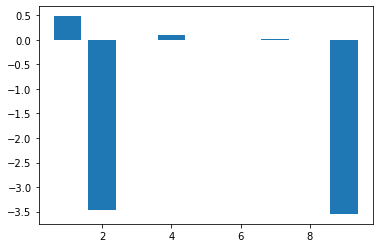

In [186]:
#Bar chart of the coefficients
plt.bar(np.linspace(1,hare_w_4.shape[0],hare_w_4.shape[0]),hare_w_4)

<BarContainer object of 9 artists>

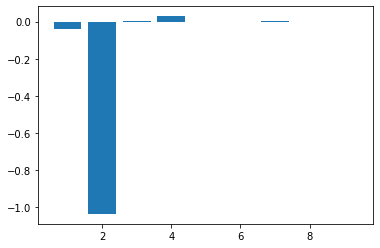

In [187]:
plt.bar(np.linspace(1,lynx_w_4.shape[0],lynx_w_4.shape[0]),lynx_w_4)

In [188]:
#Removing coefficients
coef1 = hare_w_4
coef1[2:7] = 0
coef2 = lynx_w_4
coef2[4:8] = 0
coef2[2] = 0

In [141]:
#Solving the ODE with our fitted coefficients
X0 = np.array([hare[0], lynx[0]])                     
sol4 = integrate.odeint(sparseode, X0, time, full_output=True)

In [142]:
hare4 = sol4[0][:,0]
lynx4 = sol4[0][:,1]

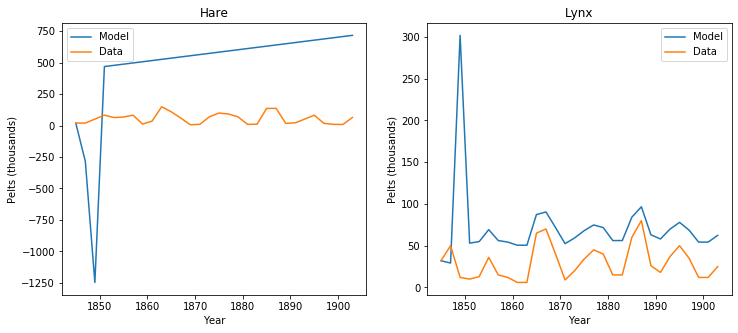

In [143]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(time,hare4)
plt.plot(time,hare)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')
plt.title('Hare')

plt.subplot(1,2,2)
plt.plot(time,lynx4)
plt.plot(time,lynx)
plt.legend(['Model','Data'])
plt.xlabel('Year')
plt.ylabel('Pelts (thousands)')
plt.title('Lynx')

plt.savefig('sps.png')

## Interpolated

In [149]:
A4_i = np.array([haref[1:-1], lynxf[1:-1], np.power(haref[1:-1],2), np.power(lynxf[1:-1],2), np.power(haref[1:-1],3), 
               np.power(lynxf[1:-1],3), (haref*lynxf)[1:-1],np.sin(haref[1:-1]), np.sin(lynxf[1:-1])])
A4_i = A4_i.T

In [150]:
clfl = Lasso(alpha=0.3)
clfl.fit(A4_i, haredot_i)
hare_w_4i = clfl.coef_
hare_w_4i = hare_w_4.transpose()

clfl.fit(A4_i, lynxdot_i)
lynx_w_4i= clfl.coef_
lynx_w_4i = lynx_w_4i.transpose()


#hare_w_4i = np.linalg.pinv(A4_i)@haredot_i
#lynx_w_4i = np.linalg.pinv(A4_i)@lynxdot_i

<BarContainer object of 9 artists>

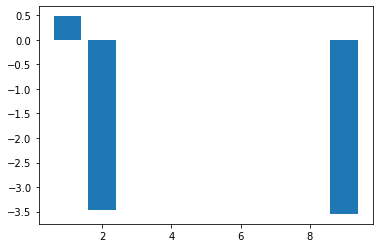

In [151]:
plt.bar(np.linspace(1,hare_w_4i.shape[0],hare_w_4i.shape[0]),hare_w_4i)

<BarContainer object of 9 artists>

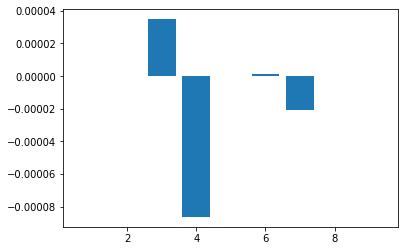

In [152]:
plt.bar(np.linspace(1,lynx_w_4i.shape[0],lynx_w_4i.shape[0]),lynx_w_4i)

In [156]:
coef1 = hare_w_4i
coef1[2:7] = 0
coef2 = lynx_w_4i
coef2[0:1] = 0
coef2[4:6] = 0

In [157]:
coef2

array([ 0.00000000e+00, -0.00000000e+00,  3.47779098e-05, -8.62748059e-05,
        0.00000000e+00,  0.00000000e+00, -2.06240374e-05, -0.00000000e+00,
        0.00000000e+00])

In [158]:
X0i = np.array([haref[0], lynxf[0]])                     
sol4i = integrate.odeint(sparseode, X0i, tfine, full_output=True)

C:\Users\Chris\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [159]:
hare4i = sol4i[0][:,0]
lynx4i = sol4i[0][:,1]

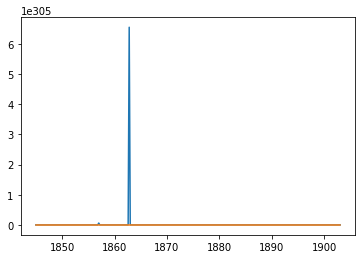

In [160]:
#really doesn't look too great

plt.plot(tfine,hare4i,'-')
plt.plot(time,hare)

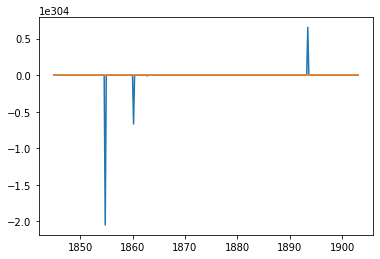

In [161]:
plt.plot(tfine,lynx4i,'-')
plt.plot(time,hare)

## KL Divergence

In [162]:
# Models:
# hare, lynx: Original data
# [hare4, lynx4]: Sparse Regression
# [LVhare, LVlynx]: Lotka-Volterra
# xth_i: Time delay DMD
# xt: DMD

#Extracting the models and removing interpolated points for consistency
hareDMD = xt[0,0::10]
lynxDMD = xt[1,0::10]

hareTDMD = xth_i[0,0::10]
lynxTDMD = xth_i[1,0::10]

In [163]:
#bins
hrange = np.arange(0,np.amax(hare)+10,10)
lrange = np.arange(0,np.amax(lynx)+10,10)
hbin = np.arange(-5,np.amax(hare)+10,10) #bin centers
lbin = np.arange(-5,np.amax(lynx)+10,10) #bin centers

#Creating PDFs
hHare = np.histogram(hare,bins=hbin)[0]+0.01
hLynx = np.histogram(lynx, bins=lbin)[0]+0.01

hHareDMD = np.histogram(hareDMD,bins=hbin)[0]+0.01
hLynxDMD = np.histogram(lynxDMD, bins=lbin)[0]+0.01

hHareTDMD = np.histogram(hareTDMD,bins=hbin)[0]+0.01
hLynxTDMD = np.histogram(lynxTDMD,bins=lbin)[0]+0.01

hHareLV = np.histogram(LVhare,bins=hbin)[0]+0.01
hLynxLV = np.histogram(LVlynx,bins=lbin)[0]+0.01

hHare4 = np.histogram(hare4,bins=hbin)[0]+0.01
hLynx4 = np.histogram(lynx4,bins=lbin)[0]+0.01

In [164]:
def normalize(inpt,rnge):
    return inpt/np.trapz(inpt,rnge)

In [165]:
#normalize
hHare = normalize(hHare,hrange)
hLynx = normalize(hLynx,lrange)

hHareDMD = normalize(hHareDMD,hrange)
hLynxDMD = normalize(hLynxDMD,lrange)

hHareTDMD = normalize(hHareTDMD,hrange)
hLynxTDMD = normalize(hLynxTDMD,lrange)

hHareLV = normalize(hHareLV,hrange)
hLynxLV = normalize(hLynxLV,lrange)

hHare4 = normalize(hHare4,hrange)
hLynx4 = normalize(hLynx4,lrange)

In [166]:
#calculating the integrand
def integrand(true,model):
    return true*np.log(np.divide(true,model))

In [167]:
#Compute integrand
DMDH = integrand(hHare,hHareDMD)
DMDL = integrand(hLynx,hLynxDMD)

TDMDH = integrand(hHare,hHareTDMD)
TDMDL = integrand(hLynx,hLynxTDMD)

LVH = integrand(hHare,hHareLV)
LVL = integrand(hLynx,hLynxLV)

SPH = integrand(hHare,hHare4)
SPL = integrand(hLynx,hLynx4)

In [168]:
# Calculate the KL divergence given the range and integrand.
def kldiv(inte, rnge):
    return np.trapz(inte,rnge)

In [169]:
#KL Divergence
KLHareDMD = kldiv(DMDH,hrange)
KLLynxDMD = kldiv(DMDL,lrange)

KLHareTDMD = kldiv(TDMDH,hrange)
KLLynxTDMD = kldiv(TDMDL,lrange)

KLHareLV = kldiv(LVH,hrange)
KLLynxLV = kldiv(LVL,lrange)

KLHare4 = kldiv(SPH,hrange)
KLLynx4 = kldiv(SPL,lrange)

In [170]:
print([KLHareDMD, KLLynxDMD],[KLHareTDMD,KLLynxTDMD],[KLHareLV,KLLynxLV],[KLHare4,KLLynx4])

[2.32193872193555, 1.8600478216489542] [1.1785699874569266, 0.7761815445031044] [1.8152505753058814, 0.2603552952866335] [1.7460961619636715, 3.8443798393854216]


## AIC BIC

In [171]:
#Calculates the AIC for a given model, data and k parameters
def AIC(data,model,k):
    n = len(data)
    res = (np.linalg.norm(data-model)**2)/n
    return (2*k + n*np.log(res))

In [172]:
#Calculates the BIC for a given model, data and k parameters
def BIC(data,model,k):
    n = len(data)
    res = (np.linalg.norm(data-model)**2)/n
    return (np.log(n)*k + n*np.log(res))

In [173]:
#DMD
hDMDAIC = AIC(hare,hareDMD,2*145)
lDMDAIC = AIC(lynx,lynxDMD,2*145)

hDMDBIC = BIC(hare,hareDMD,2*145)
lDMDBIC = BIC(lynx,lynxDMD,2*145)

#Time Delay DMD
hTDMDAIC = AIC(hare,hareTDMD,2*30)
lTDMDAIC = AIC(lynx,lynxTDMD,2*30)

hTDMDBIC = BIC(hare,hareTDMD,2*30)
lTDMDBIC = BIC(lynx,lynxTDMD,2*30)

#Lotka-Volterra
hLVAIC = AIC(hare,LVhare,2)
lLVAIC = AIC(lynx,LVlynx,2)

hLVBIC = BIC(hare,LVhare,2)
lLVBIC = BIC(lynx,LVlynx,2)

In [174]:
print([hDMDAIC,lDMDAIC,hDMDBIC,lDMDBIC],[hTDMDAIC,lTDMDAIC,hTDMDBIC,lTDMDBIC], [hLVAIC,lLVAIC,hLVBIC,lLVBIC])

[842.7764540229314, 798.3281809637667, 1249.1236947049565, 1204.6754216457919] [406.3211061966764, 343.88231941803514, 490.3929490964057, 427.9541623177645] [267.1282240270921, 222.63249847249537, 269.93061879041636, 225.4348932358197]


# BZ Data

In [175]:
import h5py

#Importing the data
filepath = 'BZ.mat'
BZ = {}
f = h5py.File(filepath)
for k, v in f.items():
    BZ[k] = np.array(v)

# The above script extracts the data into pandas
BZ = BZ['BZ_tensor']

In [176]:
# Retrieving a specific frame and putting it in the right orientation
data = np.fliplr(BZ[50,:,:])
data = data.T

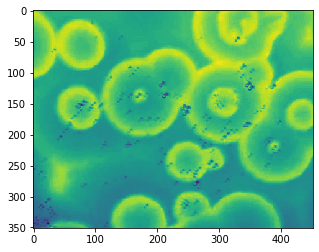

In [177]:
# 50th frame
plt.imshow(data)

plt.savefig('bzfull.png')

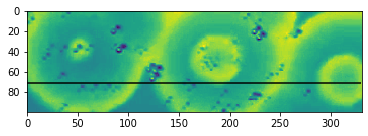

In [83]:
# Plot showing the line we are performing the DMD on
data_t = data[100:200,120:]
plt.imshow(data_t)
plt.hlines(71,0,330)

plt.savefig('bztrunc.png')

In [84]:
# Retrieving row of interest
data_row = data[171,120:]

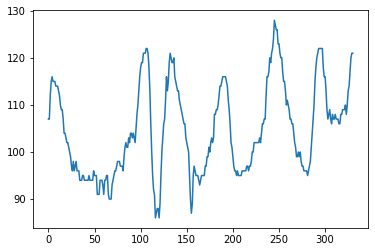

In [85]:
# Data
plt.plot(data_row)

### DMD for BZ

In [86]:
#Creating X and X'
d = data_row[0:165].reshape((1,165))
dp = data_row[1:166].reshape((1,165))

In [87]:
#Calculating DMD
b_bz, lmbda_bz, phi_bz = DMD(d,dp)

In [88]:
#Reconstructing to forecast
x_bz = predict(b_bz,lmbda_bz,phi_bz,331)

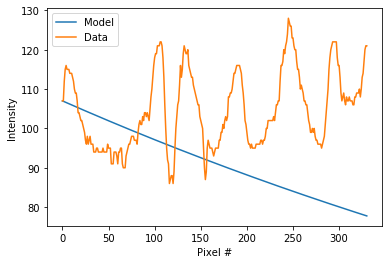

In [89]:
plt.plot(x_bz[0])
plt.plot(data_row)
plt.legend(['Model','Data'])
plt.xlabel('Pixel #')
plt.ylabel('Intensity')

plt.savefig('bzdmd.png')

### Time-Delay DMD for BZ

In [90]:
# Hankel matrix with 100 steps
bzhfull = hankel(data_row,100)

In [91]:
UBZ, SBZ, VBZ = np.linalg.svd(bzhfull,full_matrices=0)

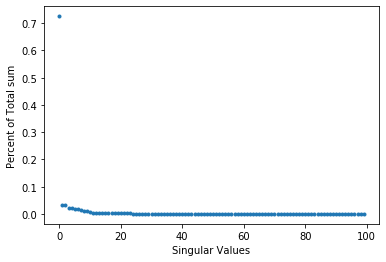

In [92]:
plt.plot(SBZ/np.sum(SBZ),'.')
plt.ylabel('Percent of Total sum')
plt.xlabel('Singular Values')

plt.savefig('SV2.png')

In [93]:
#Creating Hankel matrices for DMD forecast

bzh = hankel(data_row[0:165],50)

bzh1 = bzh[:,0:-1]
bzh2 = bzh[:,1:]

In [94]:
b_bzh, lmbda_bzh, phi_bzh = DMD(bzh1,bzh2)

In [95]:
x_bzh = predict(b_bzh,lmbda_bzh,phi_bzh,331)

C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


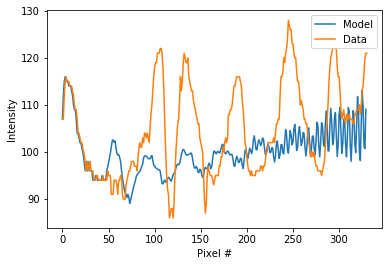

In [97]:
plt.plot(x_bzh[0,1:])
plt.plot(data_row)
plt.legend(['Model','Data'])
plt.xlabel('Pixel #')
plt.ylabel('Intensity')

plt.savefig('bztdmd.png')